# Hello and welcome to my feature importance tutorial!


**In this tutorial i will focus on feature importance and feature selection, i will simply show and explain some common feature selection methods and techniques that reveal information about the importance and other properties of features. I will not focus on performance of models or optimizing parameters.**    

**This tutorial will have a lot of comments on why certain things are done in this way and why a different approach could be problematic or not, I definitely recommend doing all the
kaggle learn courses before reading through this tutorial.**


**This notebook is oriented towards this tutorial:**  https://www.kaggle.com/apapiu/regularized-linear-models/notebook


**Hopefully it will be helpful for some of you.**


**Feel free to comment and ask questions :)**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


# Overview
 
## '1'. Data preparation
 
1. load data
1. concat train and test data to one dataframe
1. log1p transform target 'SalePrice'
1. determine numeric features 
1. calculate skewness and pick skewed features, then log1p transform them
1. dummy encode categorical variables of entire dataframe
1. fill all NaNs with mean of column
1. split up into X_train, X_test and target y

## '2'. Correlations of features

1. Analyze cross-correlation matrix    
    
    
## '3'. Use coefficients of linear models

1. Ridge model with L2 regularization
2. Lasso model with L1 regularization
3. RandomForestRegressor
    
    
## '4'. General feature selection methods
    
1. SelectKBest
2. Permutation importance
3. Shap values
4. Recursive feature elimination

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

print(train.head(), "\n")
print(train.info())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

# 1. Data preparation

This tutorial for now  focuses on feature selection and feature importance,  hence we will only do some rudimentary data processing,
such that we can fit our models. Some methods, like the dummy encoding of our target 'SalePrice' and replacing missing values are necessary 
such that the code works at all, some methods are used for getting more accurate results. 


1. Transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal 
2. Dummy encode all the categorical features
3. Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1170bdfa90>,
      dtype=object)

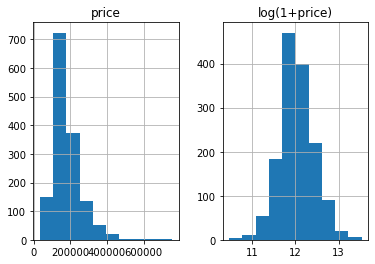

In [3]:
# we dont want to include our target SalePrice in our data, 
# hence we pick all columns except SalePrice

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))   


# now we plot the original and the log1p-transformed target SalePrice to see how it looks 

prices = pd.DataFrame({"price":train["SalePrice"], "log(1+price)":np.log1p(train["SalePrice"])})  
prices.hist()

**As we can see, the log1p transformed SalePrice looks much closer to a normal distribution than before.**

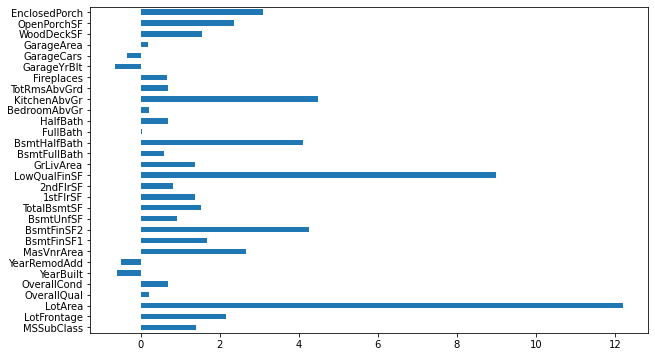

In [4]:
#log1p transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

# exclude all columns that have 'object' as dtype to get numeric columns 
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index


# compute skewness of numeric features, but
# drop NaNs since they cause errors in the skewness computation

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) 


# Now we want to plot the skewness of all numeric features
# you can also use sns.barplot(), but i find this version prettier than the sns.barplot

skewed_feats.head(30).plot(kind='barh', figsize=(10,6))    


# As you maybe already know, positive skewness can be transformed nicely with a log plot
# to make the feature 'more' normal distributed.
# Here we choose a threshold of 0.75 for the skewness, threshold must be exceeded,
# such that this skewed feature gets log1p transformed.


skewed_feats = skewed_feats[skewed_feats > 0.75]

all_data[skewed_feats.index] = np.log1p(all_data[skewed_feats.index])  

#print(all_data)

In [5]:
#  dummy encoding of our entire dataframe, it's necessary for the fitting of models.
all_data = pd.get_dummies(all_data)


#  filling NA's with the mean of the column, removing missing values/NaNs is always recommended:
all_data = all_data.fillna(all_data.mean())

print("all_data.shape: ", all_data.shape, "\n")
print("successfully dummy encoded!")

all_data.shape:  (2919, 288) 

successfully dummy encoded!


In [6]:
#  Now we split up our entire dataset into train data, test data and our target y

X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

del all_data

print(X_train.shape)
print(X_test.shape)

(1460, 288)
(1459, 288)


## 2. Correlations of features

**As you maybe already know, highly correlated features in your data can cause problems.**

**To analyze the correlations between the features we will create a cross-correlation matrix.**

**But first we need to create a dataframe containing only numeric features.**

In [7]:
print(numeric_feats, "\n")
print("number of numeric features: ", len(numeric_feats), "\n")

numeric_data = X_train[numeric_feats]

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object') 

number of numeric features:  36 



**Now that we have all the numeric features in one dataframe we can create the cross-correlation matrix.**

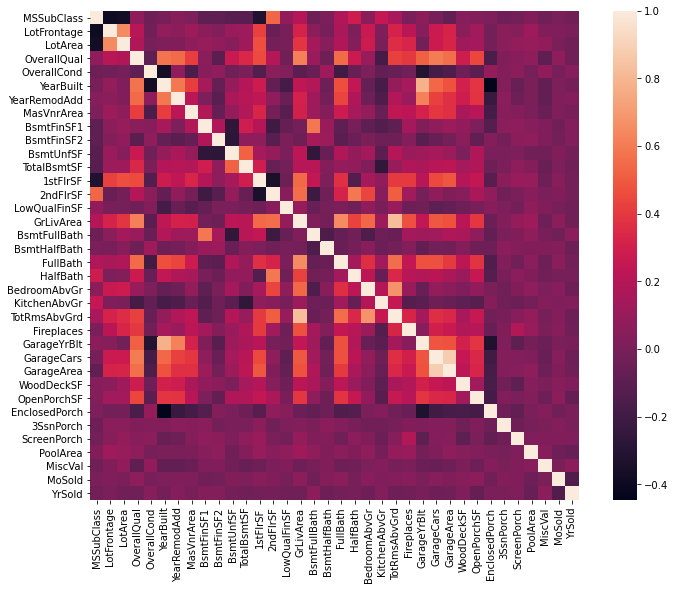

In [8]:
corrmat = numeric_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1.0, square=True);
plt.show()

**Explanation of the plot:**

**We can see a square matrix of size 36x36 and each pixel shows the cross-correlation value of feature i and feature j.**

**Hence the main diagonal is always 1, since a feature cross-correlated with itself is always 1. The brighter a pixel is, the more correlated these two features are.**

**What you do now is to look for bright pixels (except for the main diagonal of course) indicating highly correlated features.**

**I can find the following bright pixels:**

* **GarageYrBlt and YearBuilt, this makes sense because when you build the house you also build the garage at the same time**
* **GarageCars and GarageArea, this makes sense because when you have a bigger GarageArea, you can fit more cars in it**
* **TotRmsAbvGrd (Total rooms above grade) and GrLivArea, this makes sense, because the more GrLivArea a house has, the more rooms there are**

**I will not remove any of these features, since there are not many highly correlated features.**

**For example if you find huge bright areas in your cross-correlation matrix, you should remove some of these highly correlated features.**

**Or if you find one bright line of pixels, this would indicate that on feature is highly correlated with many other features, and you can then remove this feature.**

# 3. Use coefficients of linear models


**In the following section i will train two different linear models and analyze the coefficients of each model to get the most important features.**

**These two linear models, Ridge and Lasso, are simply fit to the train data, but Ridge uses the L2 regularization while Lasso uses the L1 regularization.**

**After the training process we can simply analyze the 'coefs_' attribute of the trained model, which resembles the coefficients of all features.**

1. Ridge model with L2 regularization
2. LassoCV model with L1 regularization

## 3.1 Ridge model with L2 regularization

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

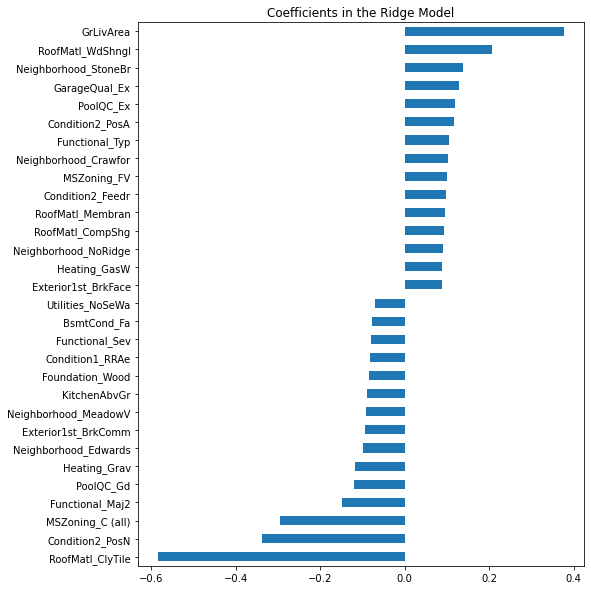

In [9]:
#####################################################################################
#     3.1.)  Ridge model with L2 regularization
#####################################################################################

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge


selector = SelectFromModel(estimator = Ridge()).fit(X_train, y)

coefs = selector.estimator_.coef_

coefs = pd.Series(coefs, index = X_train.columns)

important_coefs = pd.concat([coefs.sort_values().head(15),
                     coefs.sort_values().tail(15)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)


important_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

**As we can see we get a nice overview over the features with their corresponding coefficient, the higher the coefficient, the more important this feature is for the used model. The coefficients are distributed in a pleasant way and the values ranging from -0.6 to 0.4 look good as well.**

**We did not specify or optimize any parameters, we simply used the Ridge() model with all default parameters, now let's do the same for the Lasso model.**

In [10]:
# the top 10 features of the Ridge model are:

# GrLivArea
# RoofMatl_WdShngl
# Neighborhood_StoneBr
# GarageQual_Ex
# PoolQC_Ex
# Condition2_PosA
# Functional_Typ
# Neighborhood_Crawfor
# MSZoning_FV
# Condition2_Feedr

## 3.2 Lasso model with L1 regularization

**Now we try the Lasso model:**

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

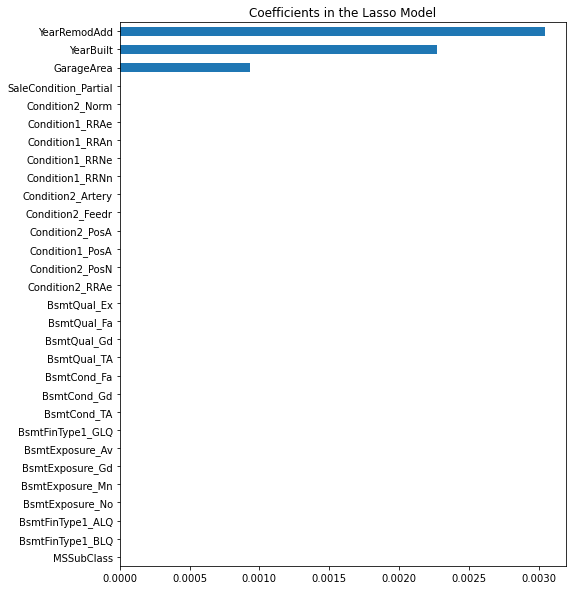

In [11]:
#####################################################################################
#     3.2.)  Lasso model with L1 regularization
#####################################################################################


from sklearn.linear_model import Lasso

selector = SelectFromModel(estimator = Lasso()).fit(X_train, y)

coefs = selector.estimator_.coef_

coefs = pd.Series(coefs, index = X_train.columns)

important_coefs = pd.concat([coefs.sort_values().head(15),
                     coefs.sort_values().tail(15)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)


important_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

**As we can see only 3 features have a coefficient that is not 0, this is a very unsatisfying result.**

**They main difference between the Ridge and the Lasso model is the different regularization term.** 

**I dont wanna go into deep mathematical detail, but simply said the regularization term looks as follows:**

**Lasso L1 regu:             alpha * |weights|**

**Ridge L2 regu:             alpha * |weights|^2**

**So the only difference lies in the squaring of the weights, the parameter alpha (called regularization strength) is the same and the default value is alpha = 1.0 for both models.**

**Increasing the parameter alpha results in smaller coefficients, hence the default value of alpha = 1.0 seems too high for the Lasso model.**

**We will lower alpha to alpha = 0.001 in the Lasso model and let's see if this helped:**

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

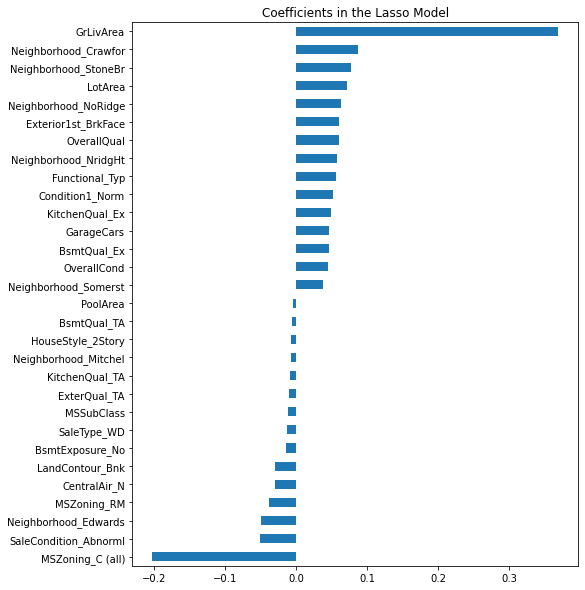

In [12]:
selector = SelectFromModel(estimator = Lasso(alpha = 0.001)).fit(X_train, y)

coefs = selector.estimator_.coef_

coefs = pd.Series(coefs, index = X_train.columns)

important_coefs = pd.concat([coefs.sort_values().head(15),
                     coefs.sort_values().tail(15)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)


important_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

**Yes, lowering the parameter alpha was definitely correct, now all the coefficients are distributed in a good way and have reasonable values from -0.2 to 0.35.**

**The problematic thing is that the parameter alpha must be optimized and tweaked in order for the model to predict accurately, but this directly influences the coefficients at the same time. And sadly the order of features changes drastically. If you compare alpha = 0.1, alpha = 0.01, and alpha = 0.001 (not shown in this notebook, but I have checked it) you get entirely different features and coefficients.** 


**Basically the 'coefs_' attribute gives us the opportunity to look into our fitted model and analyze which features the model "thinks" are important, but these coefficients are heavily influenced by parameters like the regularization strength alpha.**

# 4. General feature selection methods

**So far we have simply used the coefficients of two different linear models to find the most important features, lets try some different methods and compare the results:**

1. **Feature_selection.SelectKBest**
2. **Permutation importance**
3. **SHAP values**
4. **Recursive feature elimination (RFE)**

## 4.1 Feature_selection.SelectKBest

**In this section we are going to use the Feature_selection.SelectKBest  function of sklearn.**

**SelectKBest takes a certain score_func (score function) and runs univariate statistical tests depending on which score_func we use.**

**We do not need to train any model for this feature selection method, since only statistical calculations are carried out on the data.** 

**The common score functions used are:**

* **f_classif : used for classification tasks, uses the ANOVA F value**
* **f_regression: used for regression tasks, uses the F value**
* **chi2: used for classification tasks, uses the chi squared test**

selected_columns:  Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', 'GrLivArea',
       'FullBath', 'GarageCars', 'GarageArea', 'ExterQual_TA',
       'KitchenQual_TA'],
      dtype='object') 

sorted_scores:  [2930.799393462011, 1665.8655200142905, 1258.3494927080326, 1071.733799938272, 859.3248793731364, 802.7287168450205, 798.1003279637652, 764.7798349478579, 685.8407210053457, 594.6525692961418] 



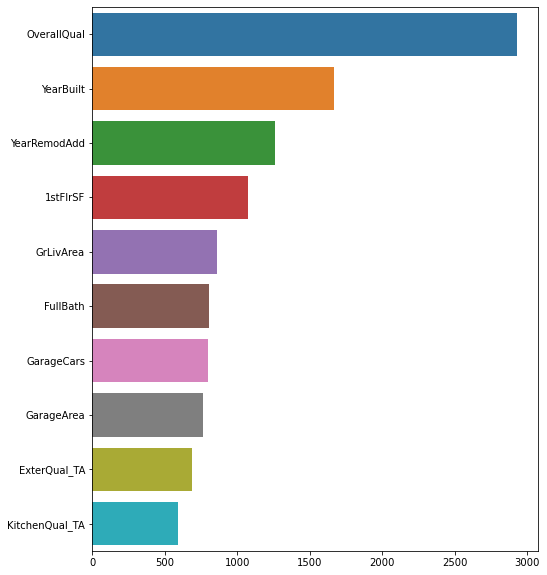

In [13]:
################################################################################################
#     4.1.)  feature_selection.SelectKBest    with f_regression
################################################################################################

#  SelectKBest works with univariate statistical tests, 
#  that calculate how the features relate with the target
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression      

feature_cols = X_train.columns


#  f_regression stands for the ANOVA F-value test and is used for regression tasks
selector = SelectKBest(score_func = f_regression, k=10)    
X_new = selector.fit_transform(X_train[feature_cols], y)
selected_features = pd.DataFrame(selector.inverse_transform(X_new),
                                 index = X_train.index,
                                 columns=feature_cols)

selected_columns = selected_features.columns[selected_features.var() != 0]  
print("selected_columns: ", selected_columns, "\n")


scores = pd.Series(selector.scores_)

sorted_scores = sorted(scores)[::-1][0:10]

print("sorted_scores: ", sorted_scores, "\n")

#print(selected_columns)
sns.barplot(sorted_scores, selected_columns, orient = "h")

**This is our second top 10 list of important features.**

In [14]:
# top10 of SelectKBest, f_regression:          

#'OverallQual', 
#'YearBuilt', 
#'YearRemodAdd', 
#'1stFlrSF', 
#'GrLivArea',
#'FullBath', 
#'GarageCars', 
#'GarageArea', 
#'ExterQual_TA',
#'KitchenQual_TA'

**This is the result for score_func = f_regression,  now we will try  score_func = mutual_info_regression**

started fitting.....

selected_columns:  Index(['MSSubClass', 'OverallQual', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'ExterQual_TA'],
      dtype='object') 

sorted_scores:  [0.5708777435891021, 0.47849771057941615, 0.3634764466709006, 0.3627595639662924, 0.361214215616249, 0.34657206929117024, 0.302662983125086, 0.28763710412812493, 0.26435329842145894, 0.26417253926704864] 



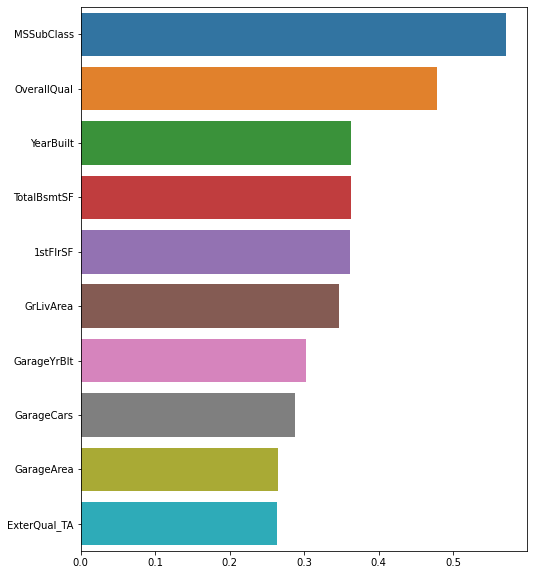

In [15]:
################################################################################################
#     4.1.)  feature_selection.SelectKBest  with mutual_info_regression
################################################################################################


#  mutual_info_regression 
selector = SelectKBest(score_func = mutual_info_regression, k=10)    

print("started fitting.....\n")
X_new = selector.fit_transform(X_train[feature_cols], y)
selected_features = pd.DataFrame(selector.inverse_transform(X_new),
                                 index = X_train.index,
                                 columns=feature_cols)

selected_columns = selected_features.columns[selected_features.var() != 0]  
print("selected_columns: ", selected_columns, "\n")


scores = pd.Series(selector.scores_)

sorted_scores = sorted(scores)[::-1][0:10]

print("sorted_scores: ", sorted_scores, "\n")

#print(selected_columns)
sns.barplot(sorted_scores, selected_columns, orient = "h")

In [16]:
# top10 of SelectKBest, mutual_info_regression:     # top10 of f_regression:      

#'MSSubClass'                                        #'OverallQual', 
#'OverallQual',                                      #'YearBuilt', 
#'YearBuilt',                                        #'YearRemodAdd', 
#'TotalBsmtSF'                                       #'1stFlrSF', 
#'1stFlrSF',                                         #'GrLivArea',
#'GrLivArea',                                        #'FullBath', 
#'GarageYrBlt',                                      #'GarageCars', 
#'GarageCars',                                       #'GarageArea', 
#'GarageArea',                                       #'ExterQual_TA',
#'ExterQual_TA',                                     #'KitchenQual_TA'

**When we compare the top10 lists of both score functions f_regression and mutual_info_regression we can see, that they have 7 features in common and in roughly the same rank and order.** 

**Since we cannot analyze any performance for these univariate statistical feature selection methods, we have to try them out one by one and compare the results afterwards.**

**For example if 4 methods yield the same result and the 5th method yields completely different results, you can assume that the first 4 methods are better in finding the important features than the 5th method.  But the final and most important test will always be the performance of the model.**

## 4.2 Permutation importance

**In this section we will use Permutation Importance to find the most important features.**

**Permutation importance is calculated after a model has been fitted by randomly shuffling the values of one single feature and then analyzing how the prediction of the model is affected by this now shuffled data.** 

**Simply said: If a feature is unimportant anyway, the prediction of a trained model does not change much when you randomly shuffle the values of an unimportant feature.**

**For more information I can recommend this kaggle course:**  https://www.kaggle.com/learn/machine-learning-explainability

In [17]:
################################################################################################
#   4.2.)  Permutation importance
################################################################################################


from IPython.display import display
import eli5
from eli5.sklearn import PermutationImportance

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


**For Permutation Importance we have to choose a list of features to calculate the permutation importance, calculating it for all 288 features would take too long. Hence we must choose about 15 features.(just for this kaggle notebook here, 15 is not a general number)** 

**Let's use the insights we already gained to choose adequate features to analyze their permutation importance.**

In [18]:
# important features so far:

# top 10 of Lasso model:         top 10 of selectKBest f_regression:  

# GrLivArea                               #'OverallQual', 
# Neighborhood_StoneBr                    #'YearBuilt', 
# Neighborhood_Crawfor                    #'YearRemodAdd', 
# Neighborhood_NoRidge                    #'1stFlrSF', 
# Functional_Typ                          #'GrLivArea',
# LotArea                                 #'FullBath',  
# Neighborhood_NridgHt                    #'GarageCars',   
# Exterior1st_BrkFace                     #'GarageArea', 
# KitchenQual_Ex                          #'ExterQual_TA',
# OverallQual                             #'KitchenQual_TA'

**Right now i will just pick the top 10 of selectKBest with f_regression and add 5 handpicked features of the Lasso model,
being  'Neighborhood_StoneBr', 'Functional_Typ', 'LotArea', 'Exterior1st_BrkFace', 'KitchenQual_Ex'.**

**I only wanted to choose one of the Neighborhood features, i picked the seemingly most important one,  and then only the other 4 remained.**

**Now we will compute the permutation importance of these features for the Ridge model, then afterwards for the Lasso model.** 

In [19]:
################################################################################################
#   4.2.1)  Permutation importance with Ridge
################################################################################################

#  which alpha to choose


X_train_short = X_train.loc[:, ['OverallQual', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', 'GrLivArea',
                                'FullBath', 'GarageCars', 'GarageArea', 'ExterQual_TA', 'KitchenQual_TA', 
                                'Neighborhood_StoneBr', 'Functional_Typ', 'LotArea', 'Exterior1st_BrkFace', 
                                'KitchenQual_Ex']]     

print("fitting model...")
my_model = Ridge().fit(X_train_short, y)

#  for performance reasons i will only use n_estimators = 100 in this tutorial,
#  i have tested it with 500 as well, the results didnt really change, 
#  but everything took much much longer to compute.


print("calculating permutation importance...(takes about 1-2 minutes)")
perm = PermutationImportance(my_model, random_state=1).fit(X_train_short, y)

display(eli5.show_weights(perm, feature_names = X_train_short.columns.tolist()))

fitting model...
calculating permutation importance...(takes about 1-2 minutes)


Weight,Feature
0.1875 ± 0.0135,GrLivArea
0.1700 ± 0.0072,OverallQual
0.0523 ± 0.0072,YearBuilt
0.0388 ± 0.0039,LotArea
0.0273 ± 0.0050,YearRemodAdd
0.0215 ± 0.0018,1stFlrSF
0.0159 ± 0.0032,GarageCars
0.0088 ± 0.0045,Functional_Typ
0.0052 ± 0.0012,KitchenQual_Ex
0.0048 ± 0.0013,Exterior1st_BrkFace


**Ok lets compare the top10 list of permutation importance with the top10 of the coefficients:**

In [20]:
# top10 of Ridge coefficients:          top10 of permutation importance:

# GrLivArea                                 # GrLivArea 
# RoofMatl_WdShngl                          # OverallQual
# Neighborhood_StoneBr                      # YearBuilt
# GarageQual_Ex                             # LotArea
# PoolQC_Ex                                 # YearRemodAdd
# Condition2_PosA                           # 1stFlrSF
# Functional_Typ                            # GarageCars
# Neighborhood_Crawfor                      # Functional_Typ
# MSZoning_FV                               # KitchenQual_Ex
# Condition2_Feedr                          # Exterior1st_BrkFace

**As we can see only 3 features appear in both top10 lists:  GrLivArea, Neighborhood_StoneBr and Functional_Typ.**

**Since we cannot know which of these 2 methods yields the "better" top10 list of features, or maybe both methods are wrong, we cannot know at this point, we have to gather more information.**

**For example if you have 5 methods for finding important features and 4 methods yield the same features, only the other method yields different results, you can safely assume that the features deemed important by these 4 methods are actually important.**

**The final test will always be the performance of the model though.**

**Let's try the Lasso model next:**

In [21]:
################################################################################################
#   4.2.2)  Permutation importance with Lasso 
################################################################################################


X_train_short = X_train.loc[:, ['OverallQual', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', 'GrLivArea',
                                'FullBath', 'GarageCars', 'GarageArea', 'ExterQual_TA', 'KitchenQual_TA', 
                                'Neighborhood_StoneBr', 'Functional_Typ', 'LotArea', 'Exterior1st_BrkFace', 
                                'KitchenQual_Ex']]     

print("fitting model...")
my_model = Lasso().fit(X_train_short, y)

#  for performance reasons i will only use n_estimators = 100 in this tutorial,
#  i have tested it with 500 as well, the results didnt really change, 
#  but everything took much much longer to compute.


print("calculating permutation importance...(takes about 1-2 minutes)")
perm = PermutationImportance(my_model, random_state=1).fit(X_train_short, y)

display(eli5.show_weights(perm, feature_names = X_train_short.columns.tolist()))

fitting model...
calculating permutation importance...(takes about 1-2 minutes)


Weight,Feature
0.5042 ± 0.0169,GarageArea
0.0895 ± 0.0068,YearBuilt
0.0841 ± 0.0097,YearRemodAdd
0 ± 0.0000,KitchenQual_Ex
0 ± 0.0000,Exterior1st_BrkFace
0 ± 0.0000,LotArea
0 ± 0.0000,Functional_Typ
0 ± 0.0000,Neighborhood_StoneBr
0 ± 0.0000,KitchenQual_TA
0 ± 0.0000,ExterQual_TA


**This is the exact same problem we had in Section 2, where the default value of alpha = 1.0 as too high, such that all coefficients were pushed down to 0, except for 3 features: GarageArea, YearBuilt, YearRemodAdd.**

**And exactly these 3 features can be found in this list right here. We will try again with a value of alpha = 0.001, let's see if we get the same features as through the coefficients:**

In [22]:
print("fitting model...")
my_model = Lasso(alpha = 0.001).fit(X_train_short, y)

#  for performance reasons i will only use n_estimators = 100 in this tutorial,
#  i have tested it with 500 as well, the results didnt really change, 
#  but everything took much much longer to compute.


print("calculating permutation importance...(takes about 1-2 minutes)")
perm = PermutationImportance(my_model, random_state=1).fit(X_train_short, y)

display(eli5.show_weights(perm, feature_names = X_train_short.columns.tolist()))

fitting model...
calculating permutation importance...(takes about 1-2 minutes)


Weight,Feature
0.1900 ± 0.0070,OverallQual
0.1689 ± 0.0125,GrLivArea
0.0493 ± 0.0067,YearBuilt
0.0393 ± 0.0040,LotArea
0.0262 ± 0.0051,YearRemodAdd
0.0213 ± 0.0016,1stFlrSF
0.0114 ± 0.0028,GarageCars
0.0067 ± 0.0038,Functional_Typ
0.0045 ± 0.0010,KitchenQual_Ex
0.0035 ± 0.0009,Exterior1st_BrkFace


**Ah well, in this list we can still find some features like GrLivArea, OverallQual and LotArea, but generally this list looks very different from the list of coefficients of the Lasso model with alpha = 0.001.**

**It seems like that in the Lasso model alpha has the same heavy impact on the results for the permutation importance as for the coefficients.**

**Let's try a model we have not looked at before:  The RandomForestRegressor.**

In [23]:
################################################################################################
#   4.2.3)  Permutation importance with RandomForestRegressor
################################################################################################

from sklearn.ensemble import RandomForestRegressor

X_train_short = X_train.loc[:, ['OverallQual', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', 'GrLivArea',
                                'FullBath', 'GarageCars', 'GarageArea', 'ExterQual_TA', 'KitchenQual_TA', 
                                'Neighborhood_StoneBr', 'Functional_Typ', 'LotArea', 'Exterior1st_BrkFace', 
                                'KitchenQual_Ex']]     

print("fitting model...")
my_model = RandomForestRegressor(n_estimators=100, random_state=1).fit(X_train_short, y)

#  for performance reasons i will only use n_estimators = 100 in this tutorial,
#  i have tested it with 500 as well, the results didnt really change, 
#  but everything took much much longer to compute.


print("calculating permutation importance...(takes about 1-2 minutes)")
perm = PermutationImportance(my_model, random_state=1).fit(X_train_short, y)

display(eli5.show_weights(perm, feature_names = X_train_short.columns.tolist()))

fitting model...
calculating permutation importance...(takes about 1-2 minutes)


Weight,Feature
0.4485 ± 0.0219,OverallQual
0.2309 ± 0.0140,GrLivArea
0.0838 ± 0.0060,1stFlrSF
0.0625 ± 0.0031,YearBuilt
0.0543 ± 0.0017,LotArea
0.0439 ± 0.0042,YearRemodAdd
0.0349 ± 0.0010,GarageArea
0.0330 ± 0.0031,GarageCars
0.0054 ± 0.0011,KitchenQual_TA
0.0043 ± 0.0005,Functional_Typ


**That looks good, when we compare this list of the RandomForestRegressor with the list of the Ridge model, we notice that they contain the same features, only the ranks and the order is slightly different.** 

**Generally one can say that the permutation importance of both the RandomForestRegressor and the Ridge model yield the same important features.**

**The problem with the permutation importance is that the results are based on a trained model, and if that model was a bad choice or is not well trained, the results of the permutation importance will not reveal any useful or correct information.**

## 4.3 Shap values

**I will not explain the Shap values in great detail,  if you are interested in that, i can recommend this link:**

https://www.kaggle.com/prashant111/explain-your-model-predictions-with-shapley-values

**Simply said SHAP values measure the impact of having a certain value for a feature in comparison to the prediction we would get if that feature took some baseline value.**

**By doing this we can detect important features.**

In [24]:
################################################################################################
#  4.3.)  SHAP Values
################################################################################################


import shap # package used to calculate Shap values
#from sklearn                        import metrics, svm
from sklearn import preprocessing
from sklearn import utils

#  This cell takes about 2 minutes to run
print("This cell takes about 2 minutes to run. \n")


#  fit model
print("fitting model...")
my_model = RandomForestRegressor(n_estimators = 100, random_state=1).fit(X_train, y) 


# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(X_train)

shap.initjs()

display(shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0,:]))

This cell takes about 2 minutes to run. 

fitting model...


**This is the typical shap value plot, i will not go into deep detail here, but we can see the most important features and how they impact the model output.**

**In these plots it's hard to compare the importance of red and blue features, but there is an awesome solution for this problem, such that we can see the most important features more clearly. Behold!**

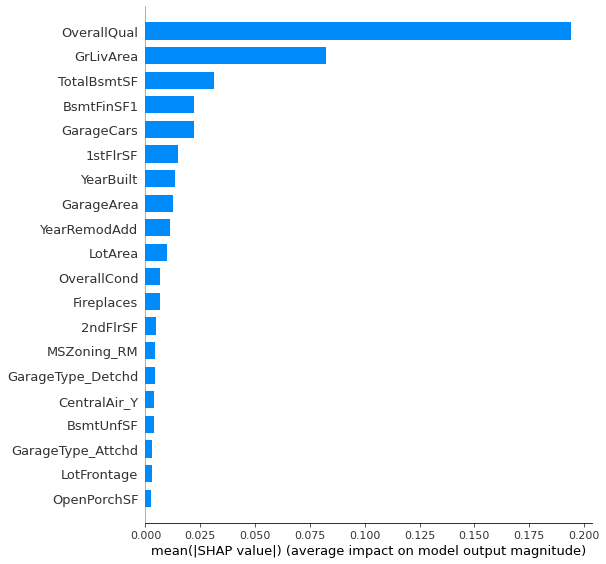

None

In [25]:
display(shap.summary_plot(shap_values, X_train, plot_type="bar"))

**Wow, isnt that beautiful? Look at this beautiful plot, the color blue, the font of the labels, the ......sorry,  i got carried away a little bit.**

**It takes about 2 minutes computation time, but we could put our entire X_train data into it and
it gives us the most important features in a very clear and structured plot.**

**Before we compare the results of this method with the results of the other methods, I want to show you one last awesome shap plot:**

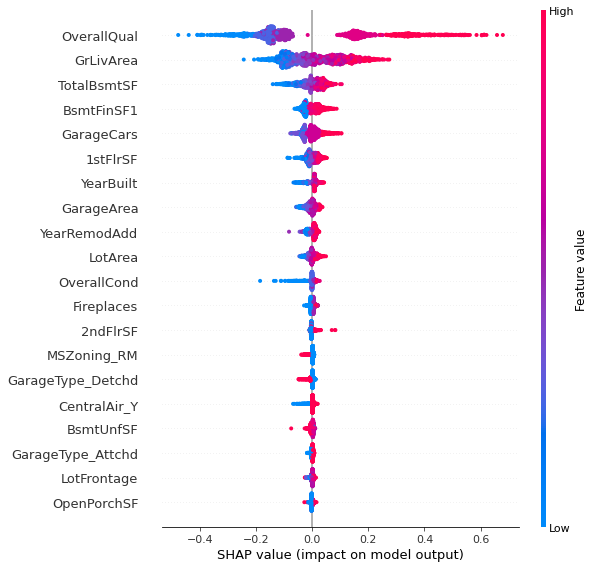

None

In [26]:
display(shap.summary_plot(shap_values, X_train))

**In this plot you can see all the features, how important they are, and how they impact the prediction.**

**When we compare the important features of the Shap values of the RandomForestRegressor with the other methods, we can again find many features, only the rank and order is changed a little bit.**

## 4.4 Recursive feature elimination

**Recursive feature elimination (RFE) works by analyzing the weights of a certain model.**

**By recursively taking smaller and smaller sets of features depending on the weights of the features, it will return the most important N features of that model.**


**RFE takes relatively long to compute compared to all other methods we used before.**

**I tried it on my PC which has a better CPU than the kaggle notebooks use,  
there it took about 10 minutes for n_features_to_select = 1, 
when i fed the entire X_train dataframe into the model.**


**I will show you the top 15 features that RFE  estimates important for the RandomForestRegressor, the code I used is below,
you can try letting it run here on kaggle, but i cannot tell you how long it will take.**

In [27]:
#################################################################
#  4.4  Recursive  Feature Elimination   (RFE)
#################################################################

'''
from sklearn.feature_selection import RFE

print("doing  recursive feature elimination...")
rfe = RFE(my_model, n_features_to_select=1)


print("fitting...")
rfe.fit(X_train, y)

from operator import itemgetter

# you have to pass the list 'features' with all the features which you trained the model with
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):   
    print(x, y)     # this line will print the rank x and the name of the feature y
'''

###########################################################################################################################

#  top 15  of the one run on my PC

#1 OverallQual
#2 GrLivArea
#3 TotalBsmtSF
#4 YearBuilt
#5 GarageCars
#6 1stFlrSF
#7 BsmtFinSF1
#8 GarageArea
#9 LotArea
#10 OverallCond
#11 YearRemodAdd
#12 CentralAir_Y
#13 LotFrontage
#14 BsmtUnfSF
#15 2ndFlrSF

'\nfrom sklearn.feature_selection import RFE\n\nprint("doing  recursive feature elimination...")\nrfe = RFE(my_model, n_features_to_select=1)\n\n\nprint("fitting...")\nrfe.fit(X_train, y)\n\nfrom operator import itemgetter\n\n# you have to pass the list \'features\' with all the features which you trained the model with\nfor x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):   \n    print(x, y)     # this line will print the rank x and the name of the feature y\n'

**When we compare this list of RFE with the other methods we have used so far,  we can find many features, some even at the same rank and position.**

# Thank you for reading my feature selection tutorial!

# Feel free to comment or ask questions :)